# Supervised

## Load model - need cai-base conda environment for this

In [ ]:
import os

from cai_garland.utils.translator import Translator, TokenizationTooLongException

In [ ]:
# translator = Translator(os.path.join("olive-cormorant-bart-pooled-context", "base-base"))

In [ ]:
translator = Translator(os.path.join("olive-cormorant-nllb-pooled-context", "base-600M"))

In [ ]:
translator.cuda()

## Load dataset

### Prep context embeddings

In [ ]:
import datasets

from cai_garland.data.context_injection_dataset import ContextInjectionDataset

In [ ]:
ContextInjectionDataset.prepare_context_embeddings(
    "processed_datasets/84000-parallel-sentences-raw-with-context/contexts.pkl",
    "facebook/bart-base",
    raw_contexts=True,
    overwrite=False
)

### Load evaluation set and join to prepped embeddings

In [ ]:
from tqdm.auto import tqdm
from transformers import AutoTokenizer

In [ ]:
eval_dataset_raw = datasets.load_dataset("../cai_garland/data/parallel_dataset_loader_hf.py", "raw_with_context", split=datasets.splits.Split.VALIDATION)
len(eval_dataset_raw)

In [ ]:
eval_dataset = ContextInjectionDataset(eval_dataset_raw, "english", raw_contexts=True)

In [ ]:
ctx_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

In [ ]:
translator.prepare_context_encoder("facebook/bart-base")

In [ ]:
translations = []
for ex in tqdm(eval_dataset):
    context = ctx_tokenizer.decode(ex['context_embedding'], skip_special_tokens=True)
    try:
        translated = translator.translate(
            ex["tibetan"],
            context=context,
            generator_kwargs={
                "repetition_penalty": 2.2,
                "no_repeat_ngram_size": 3
            }
        )
    except TokenizationTooLongException:
        continue
    translations.append({
        "prediction": translated,
        "label": ex["english"],
        "source": ex["tibetan"]
    })

### Save to temp

In [15]:
import pickle

In [16]:
os.path.join(os.environ["CAI_TEMP_PATH"], "eval_translations.pkl")

'/home/eeisenst/workspace/temp/eval_translations.pkl'

In [21]:
with open(os.path.join(os.environ["CAI_TEMP_PATH"], "eval_translations.pkl"), "wb") as f:
    pickle.dump(translations, f)

## Evaluate

### Load from temp

In [1]:
import os
import pickle

In [2]:
with open(os.path.join(os.environ["CAI_TEMP_PATH"], "eval_translations.pkl"), "rb") as f:
    translations = pickle.load(f)
len(translations)

818

### Metrics

In [3]:
import evaluate

2022-09-07 17:12:48.456820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 17:12:48.528924: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-07 17:12:48.545998: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-07 17:12:48.829611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [4]:
bleurt = evaluate.load("bleurt", 'bleurt-large-512', module_type="metric")

INFO:tensorflow:Reading checkpoint /home/eeisenst/.cache/huggingface/metrics/bleurt/bleurt-large-512/downloads/extracted/d1037a451c4066185229dd2bb1b67b15353c4dc82eb7ea0e54b2ca8e653a24b1/bleurt-large-512.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint bert_custom
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:bert_custom
INFO:tensorflow:... vocab_file:vocab.txt
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... do_lower_case:True
INFO:tensorflow:... max_seq_length:512
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating WordPiece tokenizer.
INFO:tensorflow:WordPiece tokenizer instantiated.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.


2022-09-07 17:12:54.067285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 17:12:54.069767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 17:12:54.069848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 17:12:54.070027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

INFO:tensorflow:BLEURT initialized.


In [5]:
predictions = [ex['prediction'] for ex in translations]
references = [ex['label'] for ex in translations]

In [6]:
results = bleurt.compute(predictions=predictions, references=references)

2022-09-07 17:12:59.725790: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
import pandas as pd

In [8]:
import matplotlib

<AxesSubplot:>

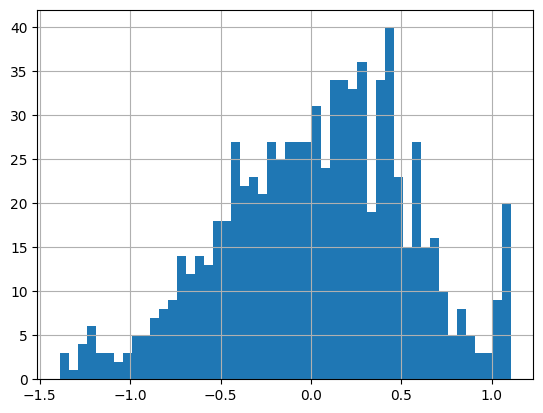

In [9]:
pd.Series(results['scores']).hist(bins=50)

In [10]:
translations = [datum | {"score": score} for datum, score in zip(translations, results['scores'])]

In [11]:
scored_df = pd.DataFrame(translations)

In [12]:
scored_df.sort_values("score")

,prediction,label,source,score
44,"seize, seize. svaha.",ksipram nirgacchata svaha,ཀྵི་ཕྲན་ནི་ར་གཙྪ་ཏ་སྭཱ་ཧཱ།,-1.388500
692,i am a humankind or a human being.,"or born of manu, or son of manu,",ཤེད་ལས་སྐྱེས་སོ་ཞེའམ། ཤེད་བུའོ་ཞེའམ,-1.363254
801,"as the hearers vehicle is a condition, there i...","at that time, there will be no classifications...",འདི་ན་ཉན་ཐོས་རྐྱེན་གྱི་ཐེག་པ་ལྟར། །དེ་ཚེ་ཐེག་པ...,-1.349489
15,"the solitary buddha thought,",it is the wish of all pratyekabuddhas.,རང་སངས་རྒྱས་ཀྱིས་བསམས་པ།,-1.304675
12,"svaha, svaha. svaka, svaka.",visarata visarata visarata visarata,བི་ས་ར་ཏ། བི་ས་ར་ཏ། བི་ས་ར་ཏ། བི་ས་ར་ཏ།,-1.286726
...,...,...,...,...
633,they do not go anywhere.,they do not go anywhere.,གང་དུ་ཡང་མི་འགྲོའོ།,1.092496
244,why is that?,why is that?,དེ་ཅིའི་ཕྱིར་ཞེ་ན།,1.094399
743,i have no protector.,i have no protector,བདག་མགོན་མ་མཆིས་ཏེ།,1.097428
120,what are those eight qualities?,what are those eight qualities?,བརྒྱད་གང་ཞེ་ན།,1.098522


In [13]:
scored_df[scored_df.score < 0].sort_values('score').iloc[-10].to_dict()

{'prediction': 'maitreya, ask whatever question you wish of the tathagata, the arhat, the totally and completely awakened buddha. with that in mind, i shall satisfy your mind.',
 'label': 'maitreya, you may put to the tathagata, the arhat, the perfectly enlightened buddha whatever question you wish. what i shall say in response to your question will cause you to rejoice.',
 'source': 'བྱམས་པ་ཁྱོད་དེ་བཞིན་གཤེགས་པ་དགྲ་བཅོམ་པ་ཡང་དག་པར་རྫོགས་པའི་སངས་རྒྱས་ལ་ཅི་དང་ཅི་འདོད་པ་དྲིས་ཤིག་དང་། དྲིས་པ་དེ་དང་དེའི་ལུང་བསྟན་པས་ངས་ཁྱོད་ཀྱི་སེམས་རངས་པར་བྱའོ།',
 'score': -0.017401888966560364}

In [14]:
scored_df.score.describe()

count    818.000000
mean       0.029740
std        0.510483
min       -1.388500
25%       -0.316826
50%        0.064777
75%        0.397213
max        1.104293
Name: score, dtype: float64

In [15]:
scored_df[scored_df.score > 0].score.describe()

count    450.000000
mean       0.404058
std        0.281985
min        0.000202
25%        0.185624
50%        0.366212
75%        0.570520
max        1.104293
Name: score, dtype: float64

<AxesSubplot:>

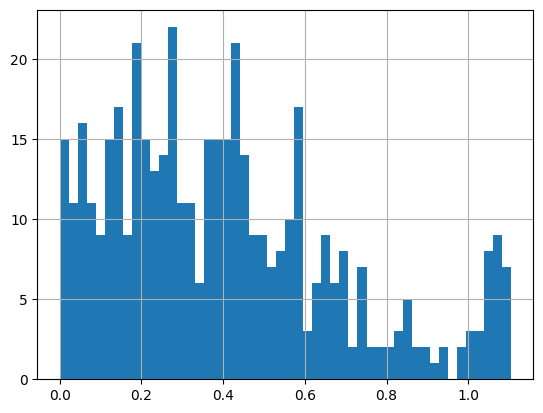

In [19]:
scored_df[scored_df.score > 0].score.hist(bins=50)